# Combining SNOMED hierarchy path lengths and word embedding cosine similarities

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
embedding_similarity_matrix = pd.read_csv('embedding_similarity_matrix.csv', index_col=0)
snomed_distance_matrix = pd.read_csv('snomed_distance_matrix.csv', index_col=0)

concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)
concept_relationship_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_RELATIONSHIP.csv', sep='\t', dtype={'concept_id_1':str, 'concept_id_2': str}, low_memory=False)

In [3]:
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

snomed_distance_matrix_norm = normalize_matrix(snomed_distance_matrix)
embedding_similarity_matrix_norm = normalize_matrix(embedding_similarity_matrix)

In [4]:
embedding_distance_matrix_norm = 1 - embedding_similarity_matrix_norm

In [43]:
alpha = 0.3  # weight for snomed distance
beta = 1 - alpha  # weight for embedding distance

combined_distance_matrix = alpha * snomed_distance_matrix_norm + beta * embedding_distance_matrix_norm

In [44]:
code_to_name = dict(zip(concept_df["concept_id"], concept_df["concept_name"]))
labels = [code_to_name[i] for i in list(combined_distance_matrix.columns)]

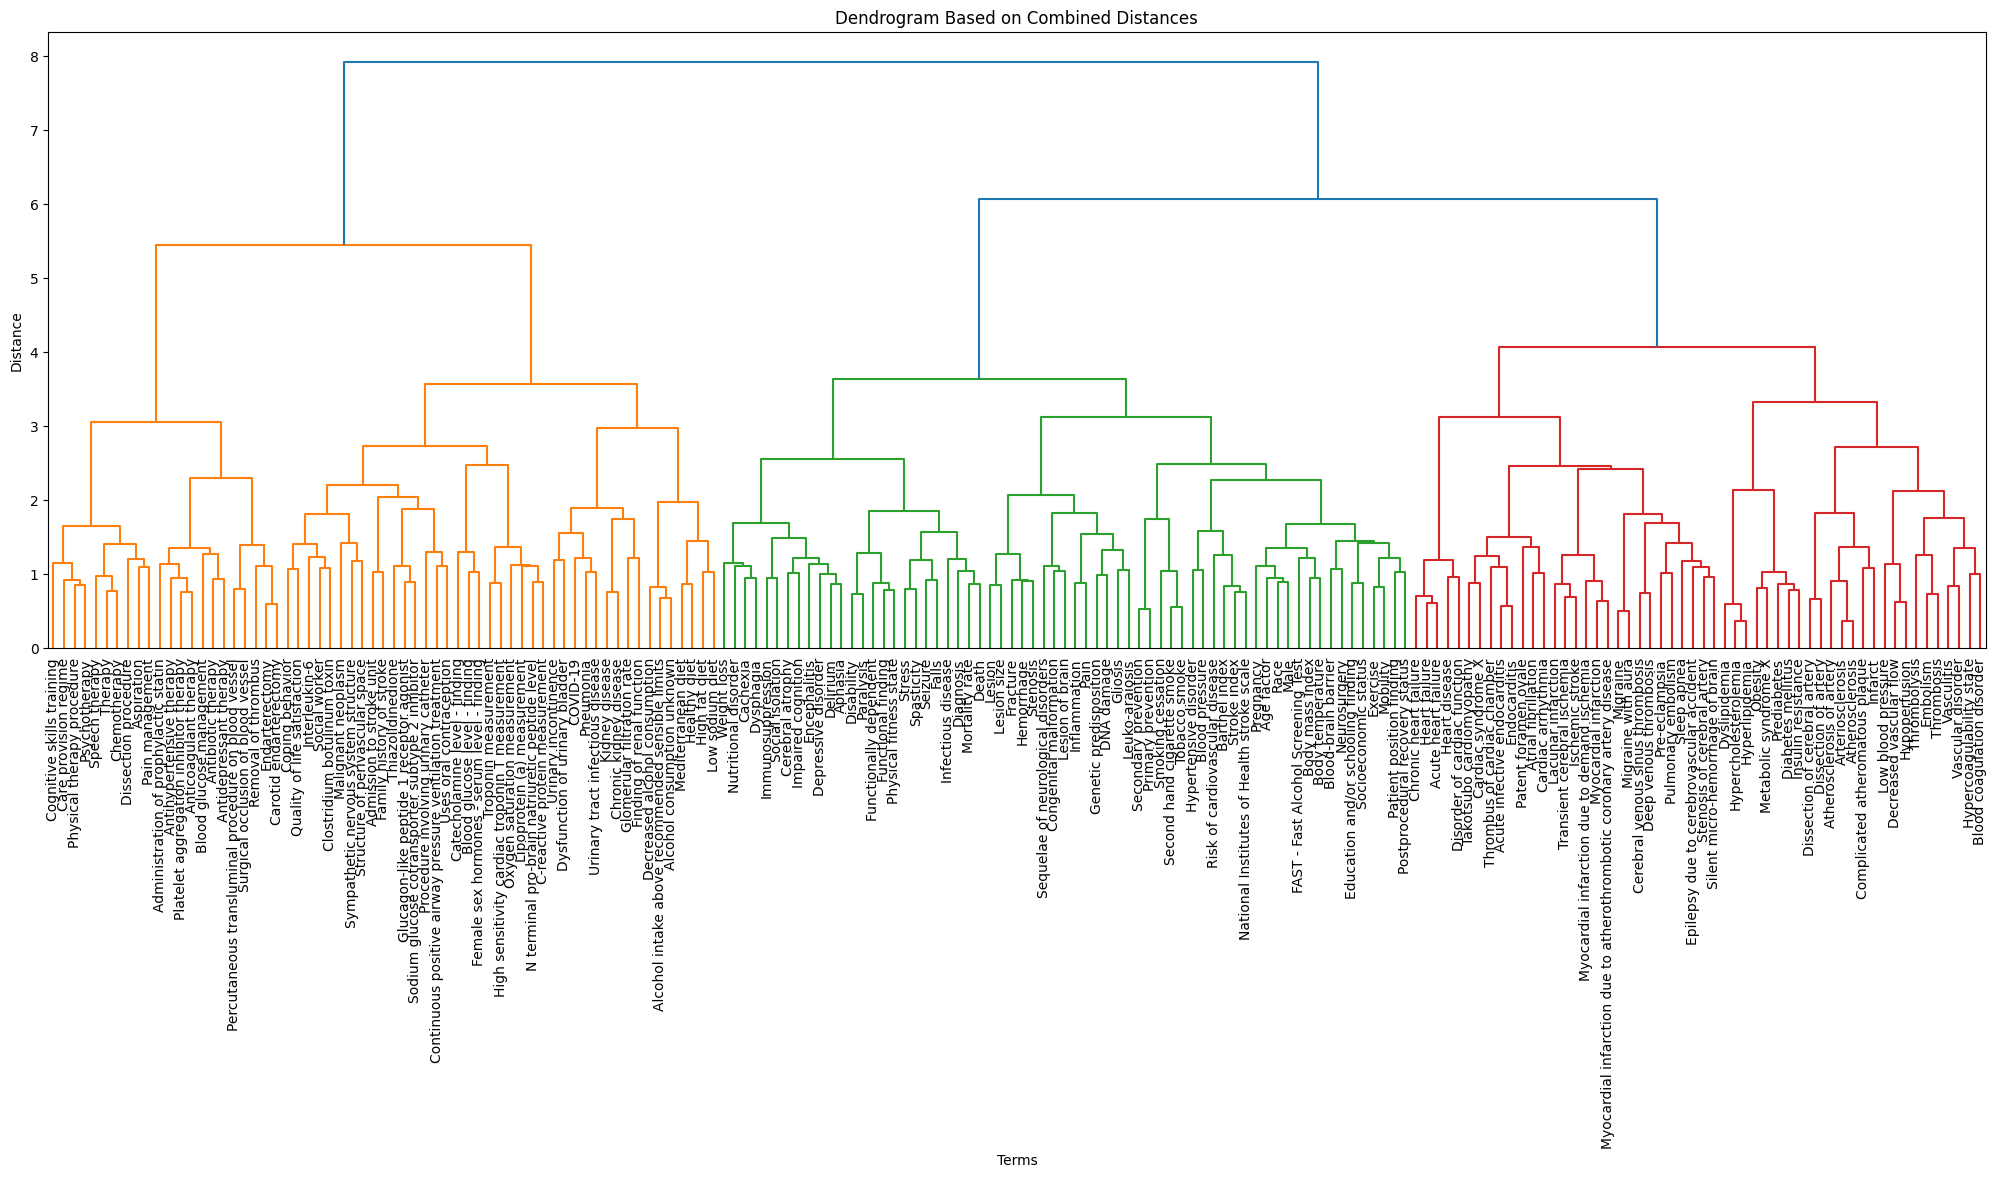

In [ ]:
linkage_matrix = linkage(combined_distance_matrix, method='ward') # check if relies on euclidian distance

plt.figure(figsize=(25, 8))
dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram Based on Combined Distances")
plt.xlabel("Terms")
plt.ylabel("Distance");

In [46]:
clusters = fcluster(linkage_matrix, t=2, criterion='distance')

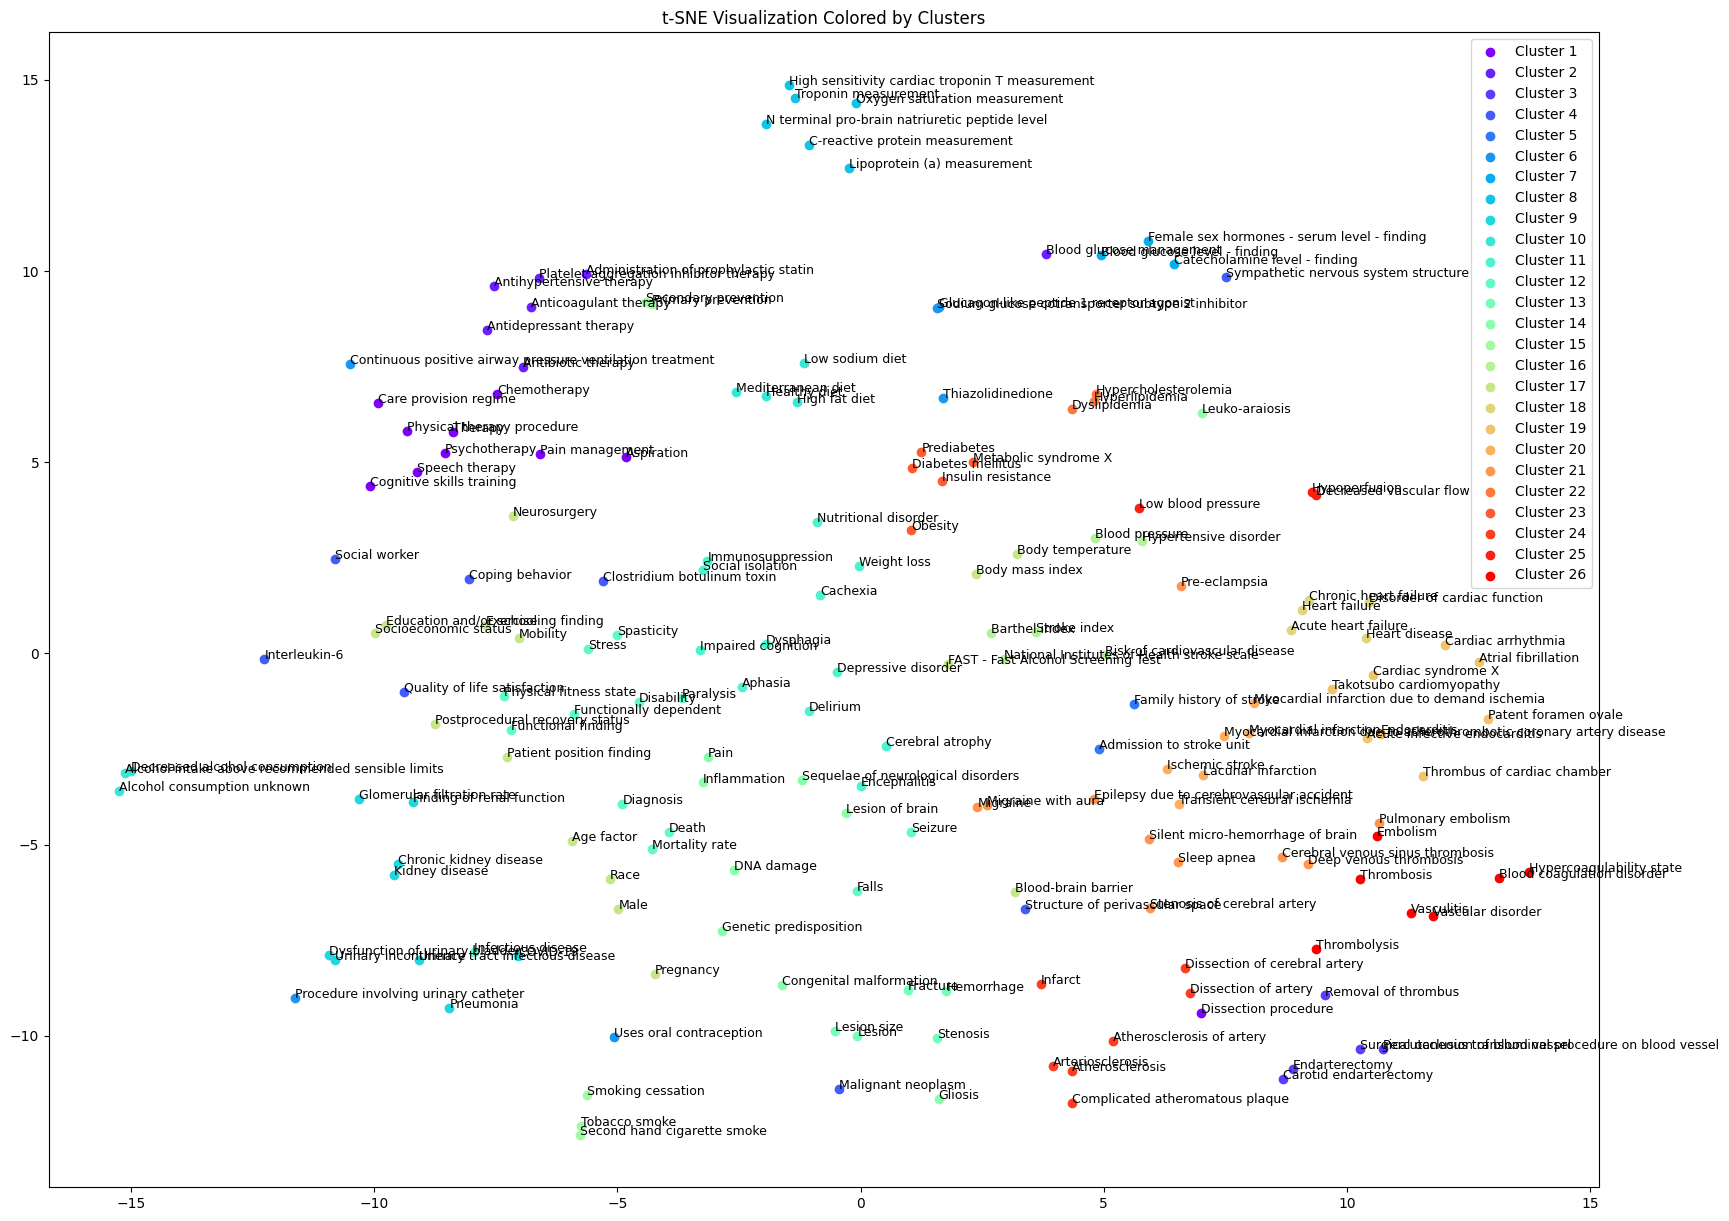

In [47]:
num_clusters = len(set(clusters))
colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

tsne = TSNE(metric="precomputed", init='random', random_state=42)
tsne_result = tsne.fit_transform(combined_distance_matrix)

plt.figure(figsize=(20, 15))
for cluster_id in range(1, num_clusters + 1):
    cluster_points = tsne_result[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", color=colors[cluster_id - 1])

for i, code in enumerate(labels):
    plt.text(tsne_result[i, 0], tsne_result[i, 1], code, fontsize=9)

plt.title("t-SNE Visualization Colored by Clusters")
plt.legend();

In [48]:
cluster_df = pd.DataFrame({'term': combined_distance_matrix.index, 'cluster': clusters})
cluster_df_count = pd.DataFrame(cluster_df.cluster.value_counts()).reset_index()
cluster_df['concept_name'] = [code_to_name[str(i)] for i in cluster_df.term]
cluster_df = cluster_df.groupby('cluster')['concept_name'].apply(list).reset_index()
cluster_df.columns = ['cluster', 'concept_names']
cluster_df = cluster_df.merge(cluster_df_count, how='left', on='cluster')
cluster_df

,cluster,concept_names,count
0,1,"[Care provision regime, Aspiration, Dissection...",10
1,2,"[Platelet aggregation inhibitor therapy, Antic...",7
2,3,[Percutaneous transluminal procedure on blood ...,5
3,4,"[Malignant neoplasm, Social worker, Clostridiu...",8
4,5,"[Admission to stroke unit, Family history of s...",2
5,6,"[Glucagon-like peptide 1 receptor agonist, Thi...",6
6,7,"[Catecholamine level - finding, Blood glucose ...",3
7,8,"[Lipoprotein (a) measurement, Oxygen saturatio...",6
8,9,"[Urinary incontinence, Kidney disease, Pneumon...",9
9,10,"[Mediterranean diet, Healthy diet, High fat di...",7


In [49]:
import re

In [50]:
my_cluster = 2
text_string = str(cluster_df.concept_names[my_cluster-1])
text_string = re.sub(r"[^a-zA-Z0-9, ]", "", text_string)
text_string

'Platelet aggregation inhibitor therapy, Anticoagulant therapy, Antibiotic therapy, Antihypertensive therapy, Administration of prophylactic statin, Blood glucose management, Antidepressant therapy'

### Find centroid and closest term as label

In [51]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
print(torch.version.cuda)  # Check installed CUDA version
print(torch.backends.cudnn.enabled)  

True
12.4
True


In [53]:
print(torch.cuda.device_count())  # Number of available GPUs
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


High Level Terms

In [54]:
snomed_concept_id = concept_df.loc[concept_df['concept_name'] == "SNOMED CT Concept", 'concept_id'].values[0]

is_a_relationships = concept_relationship_df[concept_relationship_df['relationship_id'] == 'Is a']

# Get direct children, children of children, etc. for first 3 levels of snomed hierarchy to use as summary terms
level_1 = is_a_relationships[is_a_relationships['concept_id_2'] == snomed_concept_id]['concept_id_1'].unique()
level_2 = is_a_relationships[is_a_relationships['concept_id_2'].isin(level_1)]['concept_id_1'].unique()
level_3 = is_a_relationships[is_a_relationships['concept_id_2'].isin(level_2)]['concept_id_1'].unique()

all_terms = set(level_1).union(level_2)#.union(level_3)

concept_id_to_name = dict(zip(concept_df['concept_id'], concept_df['concept_name']))
all_terms = [concept_id_to_name[concept_id] for concept_id in all_terms]
len(all_terms)

985

Function to find centroid of cluster and closest high level term associated to it

In [55]:
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def get_embeddings(terms):
    embeddings = {}
    for term in terms:
        inputs = tokenizer(term, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
        embeddings[term] = cls_embedding
    return embeddings

In [56]:
def name_clusters(cluster_df):

    closest_terms = []
    all_cluster_terms = []
    for i in range(len(cluster_df)):
        cluster_terms = cluster_df.concept_names[i]

        cluster_embeddings = get_embeddings(cluster_terms)
        cluster_embeddings_tensor = torch.stack(list(cluster_embeddings.values()))
        centroid = cluster_embeddings_tensor.mean(dim=0)

        all_term_embeddings = get_embeddings(all_terms)
        all_term_embeddings_tensor = torch.stack(list(all_term_embeddings.values()))

        centroid_norm = centroid / centroid.norm(dim=0, keepdim=True)
        all_term_embeddings_norm = all_term_embeddings_tensor / all_term_embeddings_tensor.norm(dim=1, keepdim=True)
        similarities = torch.mm(centroid_norm.unsqueeze(0), all_term_embeddings_norm.T)

        closest_term_index = torch.argmax(similarities)

        all_cluster_terms.append(cluster_terms)
        closest_terms.append(list(all_term_embeddings.keys())[closest_term_index])
    
    final_df = pd.DataFrame({'Found_Term':closest_terms, 'Cluster_Terms':all_cluster_terms})

    return final_df

In [57]:
final_df = name_clusters(cluster_df)
final_df

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,Found_Term,Cluster_Terms
0,Regimes and therapies,"[Care provision regime, Aspiration, Dissection..."
1,Control of hemorrhage,"[Platelet aggregation inhibitor therapy, Antic..."
2,Tourniquet procedure,[Percutaneous transluminal procedure on blood ...
3,Cancer-related substance,"[Malignant neoplasm, Social worker, Clostridiu..."
4,Procedure in coronary care unit,"[Admission to stroke unit, Family history of s..."
5,Uses contraception,"[Glucagon-like peptide 1 receptor agonist, Thi..."
6,Concentration of neurotransmitter in blood,"[Catecholamine level - finding, Blood glucose ..."
7,Number,"[Lipoprotein (a) measurement, Oxygen saturatio..."
8,Renotrophic organism,"[Urinary incontinence, Kidney disease, Pneumon..."
9,Inappropriate intake of types of carbohydrate,"[Mediterranean diet, Healthy diet, High fat di..."
